In [109]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_cluster import knn_graph
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import awkward as ak


In [156]:
rng = np.random.default_rng(187)

num_graphs = 256
upper_limit = 30
lower_limit = 10

graphsizes = rng.random((num_graphs))*upper_limit + lower_limit
graphsizes = graphsizes.astype(int)

In [157]:
graphsizes

array([17, 20, 25, 19, 35, 27, 30, 14, 24, 11, 30, 24, 38, 36, 15, 31, 25,
       29, 31, 33, 23, 17, 21, 31, 12, 30, 15, 17, 10, 28, 21, 17, 25, 18,
       36, 27, 19, 13, 20, 10, 27, 13, 33, 34, 12, 21, 27, 14, 36, 12, 20,
       33, 15, 22, 17, 32, 33, 26, 23, 35, 29, 24, 34, 39, 26, 35, 37, 15,
       34, 16, 34, 26, 14, 35, 37, 17, 21, 31, 31, 22, 17, 19, 20, 39, 35,
       21, 32, 33, 24, 23, 22, 38, 11, 30, 13, 18, 14, 23, 28, 36, 13, 15,
       38, 22, 35, 29, 33, 16, 26, 12, 34, 26, 11, 12, 37, 15, 28, 22, 31,
       17, 24, 12, 32, 32, 18, 18, 20, 16, 28, 32, 38, 32, 10, 29, 37, 10,
       17, 27, 25, 28, 36, 17, 31, 34, 21, 19, 36, 27, 35, 12, 18, 21, 27,
       37, 36, 10, 16, 35, 26, 32, 11, 20, 23, 27, 20, 14, 16, 18, 21, 31,
       34, 17, 15, 28, 35, 22, 15, 21, 26, 18, 12, 25, 30, 32, 13, 15, 30,
       16, 15, 30, 34, 33, 27, 24, 28, 14, 37, 33, 25, 23, 13, 26, 27, 12,
       27, 27, 13, 30, 19, 23, 37, 11, 39, 17, 33, 22, 26, 33, 24, 11, 21,
       23, 31, 30, 27, 17

In [158]:
# make node features and labels
node_features = []
for size in graphsizes:
    node_features.append(rng.random((2, size)))

In [159]:
# labels and transpose nodes into proper format and make edges
num_edges = 2
labels = []
edges = []
for i in range(len(node_features)):
    labels.append(torch.Tensor([node_features[i][0].mean(), node_features[i][1].mean()]))
    node_features[i] = torch.Tensor(np.transpose(node_features[i]))
    edges.append(knn_graph(torch.Tensor(np.transpose(node_features[i])), num_edges))
#node_features = torch.Tensor(node_features)
#torch does not allow to stack variable size tensors
#test = torch.nested.nested_tensor([node_features])
print(len(labels), len(node_features), len(edges))

256 256 256


In [160]:
len(node_features)

256

In [161]:
#raw_data = np.transpose([node_features, edges, labels])

graph_data = []

for i in range(len(node_features)):
    graph_data.append(Data(x=node_features[i], edge_index=edges[i], y=labels[i]))

In [162]:

train_graphs = graph_data[:int(num_graphs/2)]
test_graphs = graph_data[int(num_graphs/2):]

train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

print(len(train_graphs), len(test_graphs))

128 128


In [163]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [164]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    mloss = 0
    for data in loader:  # Iterate in batches over the training/test dataset
        out = model(data.x, data.edge_index, data.batch)
        mloss += criterion(out, data.y) / data.num_graphs
    return mloss

In [165]:


print(model)

GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


In [166]:
for epoch in range(1, 16):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.4587, Test Acc: 0.4813
Epoch: 002, Train Acc: 0.5080, Test Acc: 0.4976
Epoch: 003, Train Acc: 0.4851, Test Acc: 0.5106
Epoch: 004, Train Acc: 0.4156, Test Acc: 0.4406
Epoch: 005, Train Acc: 0.3022, Test Acc: 0.3133
Epoch: 006, Train Acc: 0.2905, Test Acc: 0.2999
Epoch: 007, Train Acc: 0.3811, Test Acc: 0.3750
Epoch: 008, Train Acc: 0.2337, Test Acc: 0.2339
Epoch: 009, Train Acc: 0.1675, Test Acc: 0.1825
Epoch: 010, Train Acc: 0.0973, Test Acc: 0.1125
Epoch: 011, Train Acc: 0.1585, Test Acc: 0.1453
Epoch: 012, Train Acc: 0.1728, Test Acc: 0.1969
Epoch: 013, Train Acc: 0.0864, Test Acc: 0.0997
Epoch: 014, Train Acc: 0.1981, Test Acc: 0.2168
Epoch: 015, Train Acc: 0.2580, Test Acc: 0.2804


In [167]:
#print(node_features)
test = ak.Array(node_features)
#raw_data = ([ ak.Array(node_features), ak.Array(edges), ak.Array(labels) ])
raw_data = ([node_features, edges, labels])
print(raw_data)

#graph_data = []
#for graph in raw_data[0]:
#    graph_data.append(Data(x=graph[0], edge_index=graph[1], y=graph[2]))

#print(graph_data)

[[tensor([[0.5384, 0.7038],
        [0.5891, 0.1984],
        [0.1964, 0.8458],
        [0.2354, 0.9424],
        [0.4465, 0.0666],
        [0.8466, 0.5285],
        [0.0021, 0.2904],
        [0.1976, 0.6551],
        [0.4340, 0.5579],
        [0.3812, 0.5227],
        [0.0646, 0.6813],
        [0.9763, 0.1134],
        [0.3427, 0.2231],
        [0.0216, 0.1249],
        [0.7544, 0.4564],
        [0.1742, 0.8846],
        [0.4643, 0.6982]]), tensor([[0.2358, 0.3899],
        [0.1028, 0.5678],
        [0.1836, 0.8252],
        [0.7065, 0.3822],
        [0.2518, 0.9879],
        [0.6772, 0.2185],
        [0.0383, 0.5648],
        [0.8327, 0.9064],
        [0.7879, 0.8468],
        [0.5541, 0.7023],
        [0.0292, 0.6411],
        [0.5521, 0.1713],
        [0.8962, 0.1748],
        [0.0277, 0.9287],
        [0.2051, 0.0158],
        [0.1178, 0.0163],
        [0.8765, 0.3505],
        [0.8032, 0.8022],
        [0.6309, 0.5486],
        [0.6676, 0.6537]]), tensor([[0.0694, 0.4680],
      

# Old Code

In [29]:
rng = np.random.default_rng(12345)

nodes = []
nodes.append(rng.random((2, 13)))
labels = []
for node in nodes:
    labels.append([node[0].mean(), node[1].mean()])

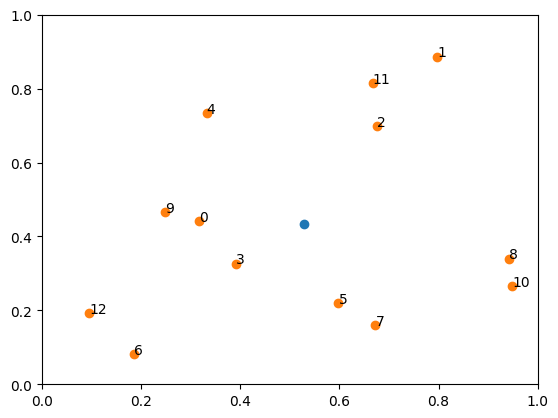

In [24]:
# Plot graph in physical space

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(labels[0][0], labels[0][1])
ax.scatter(nodes[0][0], nodes[0][1])
ax.set_xlim(0,1)
ax.set_ylim(0,1)

for i in range(len(nodes[0][0])):
    ax.annotate(i, (nodes[0][0][i], nodes[0][1][i]))

In [28]:
print(nodes[0])
labelplot = np.transpose(labels)
for i in range(len(nodes)):
    nodes[i] = np.transpose(nodes[i])
print(nodes[0])
edge_index = knn_graph(torch.Tensor(nodes[0]), 1)
print(edge_index)

[[0.31675834 0.79736546 0.67625467 0.39110955 0.33281393 0.59830875
  0.18673419 0.67275604 0.94180287 0.24824571 0.94888115 0.66723745
  0.09589794]
 [0.44183967 0.88647992 0.6974535  0.32647286 0.73392816 0.22013496
  0.08159457 0.1598956  0.34010018 0.46519315 0.26642103 0.8157764
  0.19329439]]
[[0.31675834 0.44183967]
 [0.79736546 0.88647992]
 [0.67625467 0.6974535 ]
 [0.39110955 0.32647286]
 [0.33281393 0.73392816]
 [0.59830875 0.22013496]
 [0.18673419 0.08159457]
 [0.67275604 0.1598956 ]
 [0.94180287 0.34010018]
 [0.24824571 0.46519315]
 [0.94888115 0.26642103]
 [0.66723745 0.8157764 ]
 [0.09589794 0.19329439]]
tensor([[ 9, 11, 11,  0,  9,  7, 12,  5, 10,  0,  8,  2,  6],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])


In [18]:
def dist(node1, node2):
    x = np.absolute(node1[0] - node2[0])
    y = np.absolute(node1[1] - node2[1])
    return np.sqrt(np.power(x,2) + np.power(y,2))

def kNN(nodes):
    alldist = []
    for i in range(len(nodes)):
        distances = []
        for j in range(len(nodes)):
            distances.append(dist(nodes[i], nodes[j]))
        alldist.append(distances)
    return alldist

def kNN_full(dist, k):
    for i in range(len(dist)):
        